# **Fake review detection using classic ML models**



---



## **1) Data Preprocessing**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords

from scipy.sparse import hstack

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import matthews_corrcoef, average_precision_score
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### Data loading

In [2]:
train_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/yelp_new_data_train.csv", index_col=0)

test_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/yelp_new_data_test.csv", index_col=0)

In [3]:
train_df.head()

,reviewID,reviewerID,restaurantID,date,rating,reviewUsefulCount,reviewContent,flagged,name,location,...,reviewCount,firstCount,usefulCount,coolCount,funnyCount,complimentCount,tipCount,fanCount,restaurantRating,ReviewLength
6010,Z_wgGcI8_Txo87Wz7CxdrQ,cM9GIlk61Qh2thLyJyxNyA,N7juvW8YoFIj7sEBzVF8GQ,17-09-2010,5,0,as new resident chicago los angeles i mission ...,1,suzie n.,"Los Angeles, CA",...,1,0,1,2,0,0,0,0,4.0,144
6566,NJfQb03MSstqYagt860Oaw,SVlSPBnjCzY2Bu9n8y2C5A,o54U2VkQama8FI30qDkWvw,31-01-2008,5,0,great place rarely wait fairly easy find parki...,0,Jacqui B.,"Kalamazoo, MI",...,12,2,19,7,6,4,0,0,4.0,46
21349,2uao3bK9iSV4fuMwuSYCiQ,5HYWhPS3ozYifieW0lWMUw,1QKqtC4vML3QhkrSzwR_tQ,31-03-2010,5,0,back bar makes feel though transported china s...,1,Mike A.,"Los Angeles, CA",...,6,0,7,3,2,0,0,0,3.5,18
10370,6mVU2JfeSbQ-5RnPm-K6eA,dgKmhiTypR34XNPrMtQyMA,4wreIFjaPMppyEnzKHbozg,26-04-2010,5,0,hands one favorite tourist restaurants city th...,0,Jen K.,"Chicago, IL",...,37,2,16,3,3,1,0,1,3.5,41
6011,e25NUAMnVf7-t8-vBO_drA,uB3n74XHDFUKwHxfK5lDvA,N7juvW8YoFIj7sEBzVF8GQ,07-09-2010,5,0,service impeccable staff helpful owner works h...,1,Joe K.,"Barrington, IL",...,3,0,2,1,0,0,0,0,4.0,40


In [4]:
train_df.shape, test_df.shape

((9929, 22), (2483, 22))

In [5]:
train_df.flagged.value_counts()

,count
flagged,
0,4994
1,4935


In [6]:
test_df.flagged.value_counts()

,count
flagged,
1,1271
0,1212


### Data cleaning and feature selection

In [7]:
train_df[train_df['reviewContent'].isnull()]

,reviewID,reviewerID,restaurantID,date,rating,reviewUsefulCount,reviewContent,flagged,name,location,...,reviewCount,firstCount,usefulCount,coolCount,funnyCount,complimentCount,tipCount,fanCount,restaurantRating,ReviewLength
15972,vPx7Ga3vAB7ZLfZsQChlSA,QasfZU1HgCW4LNU8AFFfwg,LMaoM2Ue2BR_HI9ba3JsZg,23-08-2012,4,0,NaN,0,Robert H.,"Denver, CO",...,84,2,16,23,6,9,1,2,4.0,1
25462,ln1j0sucN56GF7NaXqvtkQ,FezvtjI9VD4PZR0vIq-9IQ,43rd1LKcZRIunySzbMsyLQ,12-09-2007,5,0,NaN,1,Txema G.,"Chicago, IL",...,1,0,0,0,1,0,0,0,4.5,1
20728,f83DnEX60KDNk9rqInjWwg,TPOQUpDTdFMPeZwO2nOWQA,O6uWHgJzylSjWjPSJKGhnQ,16-12-2007,3,0,NaN,1,ozlem v.,"Chicago, IL",...,2,0,1,1,0,0,0,0,4.0,1


In [8]:
train_df = train_df[~train_df['reviewContent'].isnull()]

In [9]:
train_df.shape

(9926, 22)

In [10]:
train_df = train_df[['reviewContent', 'rating', 'reviewUsefulCount', 'friendCount', 'reviewCount', 'firstCount', 'usefulCount', 'coolCount', 'funnyCount', 'complimentCount', 'tipCount', 'fanCount', 'restaurantRating', 'ReviewLength', 'flagged']]

train_df

,reviewContent,rating,reviewUsefulCount,friendCount,reviewCount,firstCount,usefulCount,coolCount,funnyCount,complimentCount,tipCount,fanCount,restaurantRating,ReviewLength,flagged
6010,as new resident chicago los angeles i mission ...,5,0,0,1,0,1,2,0,0,0,0,4.0,144,1
6566,great place rarely wait fairly easy find parki...,5,0,5,12,2,19,7,6,4,0,0,4.0,46,0
21349,back bar makes feel though transported china s...,5,0,0,6,0,7,3,2,0,0,0,3.5,18,1
10370,hands one favorite tourist restaurants city th...,5,0,2,37,2,16,3,3,1,0,1,3.5,41,0
6011,service impeccable staff helpful owner works h...,5,0,0,3,0,2,1,0,0,0,0,4.0,40,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2072,confirming owner s helpful suggestion trick ab...,4,1,61,518,79,538,222,258,111,16,15,4.0,83,0
20930,this best pizza chicago possibly world they am...,5,0,0,3,0,2,0,0,0,0,0,4.0,46,1
2420,i love place great beer great service fantasti...,5,0,0,8,0,0,0,0,0,0,0,4.0,16,1
3090,i always passed place never chance come in fin...,4,0,1,2,0,0,0,0,1,1,0,4.0,125,1


In [11]:
test_df = test_df[['reviewContent', 'rating', 'reviewUsefulCount', 'friendCount', 'reviewCount', 'firstCount', 'usefulCount', 'coolCount', 'funnyCount', 'complimentCount', 'tipCount', 'fanCount', 'restaurantRating', 'ReviewLength', 'flagged']]
test_df

,reviewContent,rating,reviewUsefulCount,friendCount,reviewCount,firstCount,usefulCount,coolCount,funnyCount,complimentCount,tipCount,fanCount,restaurantRating,ReviewLength,flagged
7267,sunda amazing i heard many good things finally...,4,0,0,1,0,0,0,0,0,0,0,4.0,72,1
731,absolutely fantastic foodie community table gr...,4,0,0,1,0,0,0,0,0,5,0,4.0,12,0
9902,i work right rarely go here they 5 personal st...,3,0,295,845,143,2499,1451,1151,1377,2,55,3.5,102,0
25894,this best big 3 brazilian steakhouses chicago ...,3,0,1,2,0,0,0,0,0,0,0,4.0,30,1
17519,i lunch the gage group 8 this first time there...,4,0,0,1,0,0,0,0,0,0,0,4.0,93,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13196,there better steak chicago opinion the lobster...,5,0,0,3,0,0,0,2,0,0,0,4.0,16,1
10278,it controversial topic i believe giordano s be...,4,0,4,11,0,0,0,0,0,0,0,3.5,35,1
11476,this place outrageous i went drinks girls thur...,1,0,0,1,0,1,0,0,0,0,0,4.0,97,1
24962,ha i ve eating lunch least twice week two year...,4,0,5,27,0,25,4,4,0,0,1,4.0,49,0


### Text preprocessing

In [12]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
stop_words = list(set(stopwords.words("english")))

In [14]:
tfidf_train = TfidfVectorizer(
    strip_accents="unicode",
    lowercase=True,
    stop_words=stop_words,
    ngram_range=(1,2),
    min_df=3,
    max_features=10000,
    sublinear_tf=True
)

X_train = tfidf_train.fit_transform(train_df["reviewContent"])

X_test = tfidf_train.transform(test_df["reviewContent"])

### Numerical feature engineering

In [15]:
skewed_cols = ['reviewUsefulCount', 'friendCount', 'reviewCount', 'firstCount', 'usefulCount', 'coolCount', 'funnyCount', 'complimentCount', 'tipCount', 'fanCount', 'ReviewLength']
rating_cols = ['rating', 'restaurantRating']

for col in skewed_cols:
    train_df[col] = np.log1p(train_df[col])
    test_df[col]  = np.log1p(test_df[col])

scaler = MinMaxScaler()
num_cols = skewed_cols + rating_cols

X1_train = scaler.fit_transform(train_df[num_cols])
X1_test  = scaler.transform(test_df[num_cols])

### Preparing train and test data

In [16]:
X_train = hstack((X_train, X1_train))

X_test = hstack((X_test, X1_test))

In [17]:
y_train = train_df['flagged']
y_train

,flagged
6010,1
6566,0
21349,1
10370,0
6011,1
...,...
2072,0
20930,1
2420,1
3090,1


In [18]:
y_test = test_df['flagged']
y_test

,flagged
7267,1
731,0
9902,0
25894,1
17519,1
...,...
13196,1
10278,1
11476,1
24962,0


In [19]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(9926, 10013)
(2483, 10013)
(9926,)
(2483,)


### Utility function to calculate metrics

In [20]:
def calculate_metrics(y_true, y_pred):
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary")
  model_mcc = float(matthews_corrcoef(y_true, y_pred))
  model_auc_roc = float(roc_auc_score(y_true, y_pred))
  model_auc_pr = float(average_precision_score(y_true, y_pred))
  model_cm = confusion_matrix(y_true, y_pred)
  model_results = {"accuracy": model_accuracy,
                   "precision": model_precision * 100,
                   "recall": model_recall * 100,
                   "f1": model_f1 * 100,
                   "mcc": model_mcc,
                   "auc-roc": model_auc_roc,
                   "auc-pr" : model_auc_pr,
                   "confusion_matrix": model_cm.tolist()
                   }
  return model_results

In [21]:
model_results = {}

## **2) Logistic Regression Model training and Evaluation**

### Model training

In [22]:
lr = LogisticRegression(max_iter=2000, random_state = 42)
lr.fit(X_train, y_train)

preds_test = lr.predict(X_test)

### Export predictions to csv

In [23]:
lr_output = pd.DataFrame({'text': test_df['reviewContent'],
                          'true_label': y_test.values,
                          'pred': preds_test})
lr_output.to_csv("logistic_regression.csv", index=False)

### Model evaluation

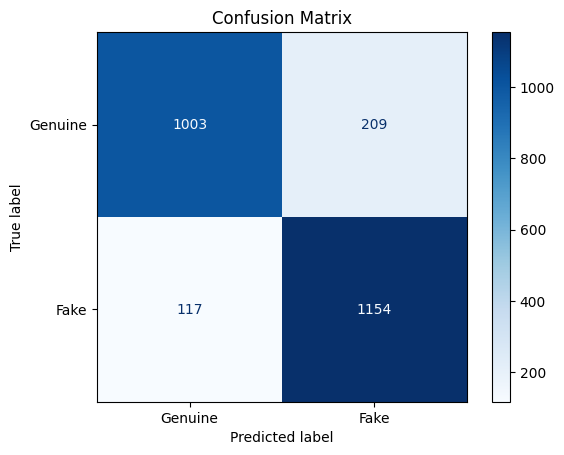

In [24]:
cm = confusion_matrix(y_test, preds_test)
cmd = ConfusionMatrixDisplay(cm, display_labels=['Genuine','Fake'])
cmd.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

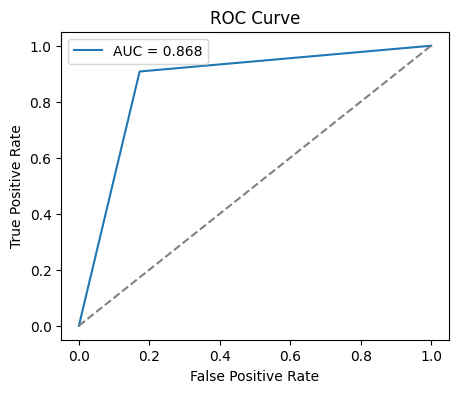

In [25]:
fpr, tpr, thresholds = roc_curve(y_test, preds_test)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

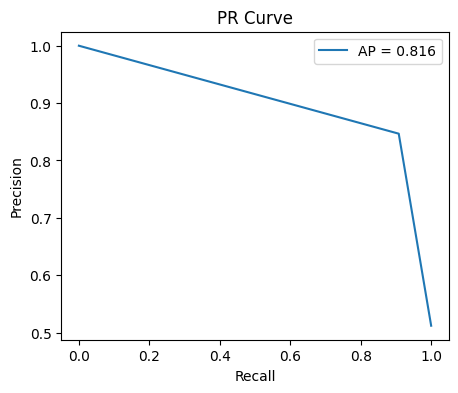

In [26]:
precision, recall, thresholds = precision_recall_curve(y_test, preds_test)
avg_precision = average_precision_score(y_test, preds_test)

plt.figure(figsize=(5, 4))
plt.plot(recall, precision, label=f"AP = {avg_precision:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR Curve")
plt.legend()
plt.show()

In [27]:
lr_results = calculate_metrics(y_test, preds_test)
model_results["Logistic Regression"] = lr_results
lr_results

{'accuracy': 86.87072090213451,
 'precision': 84.66617754952311,
 'recall': 90.79464988198269,
 'f1': 87.62338648443432,
 'mcc': 0.7388432929139404,
 'auc-roc': 0.8677521272977022,
 'auc-pr': 0.815844013593641,
 'confusion_matrix': [[1003, 209], [117, 1154]]}

## **3) Random Forest Model training and Evaluation**

### Model training

In [28]:
rf = RandomForestClassifier(n_estimators=300,
                            random_state=42,
                            max_depth=None,
                            n_jobs=-1)
rf.fit(X_train, y_train)

preds_test = rf.predict(X_test)

### Export predictions to csv

In [29]:
rf_output = pd.DataFrame({'text': test_df['reviewContent'],
                          'true_label': y_test.values,
                          'pred': preds_test})
rf_output.to_csv("random_forest.csv", index=False)

### Model evaluation

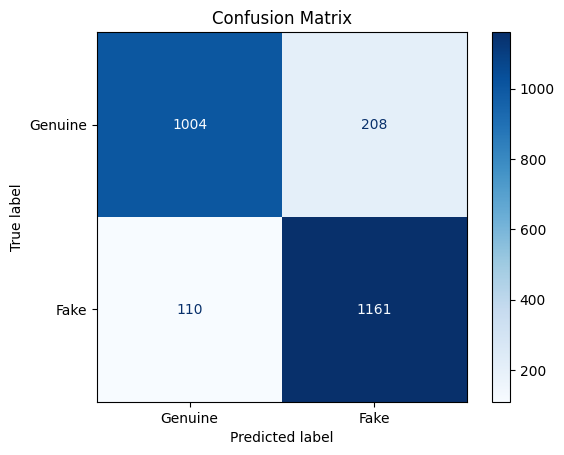

In [30]:
cm = confusion_matrix(y_test, preds_test)
cmd = ConfusionMatrixDisplay(cm, display_labels=['Genuine','Fake'])
cmd.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

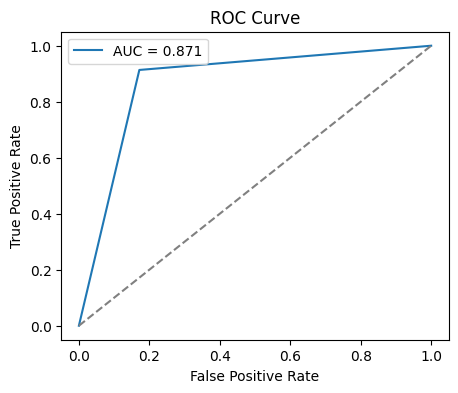

In [31]:
fpr, tpr, thresholds = roc_curve(y_test, preds_test)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

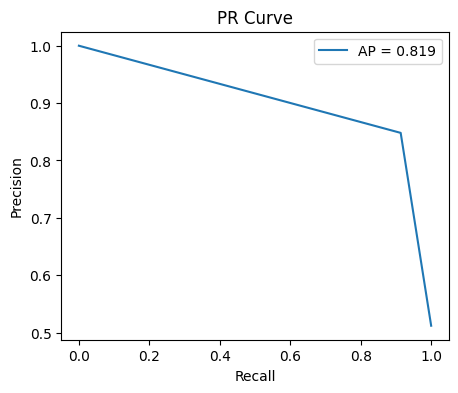

In [32]:
precision, recall, thresholds = precision_recall_curve(y_test, preds_test)
avg_precision = average_precision_score(y_test, preds_test)

plt.figure(figsize=(5, 4))
plt.plot(recall, precision, label=f"AP = {avg_precision:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR Curve")
plt.legend()
plt.show()

In [33]:
rf_results = calculate_metrics(y_test, preds_test)
model_results["Random Forest"] = rf_results
rf_results

{'accuracy': 87.19291180024165,
 'precision': 84.8064280496713,
 'recall': 91.34539732494099,
 'f1': 87.95454545454545,
 'mcc': 0.745569521301004,
 'auc-roc': 0.8709184057666193,
 'auc-pr': 0.8189689350803546,
 'confusion_matrix': [[1004, 208], [110, 1161]]}

## **4) Model Comparision**

In [34]:
model_results

{'Logistic Regression': {'accuracy': 86.87072090213451,
  'precision': 84.66617754952311,
  'recall': 90.79464988198269,
  'f1': 87.62338648443432,
  'mcc': 0.7388432929139404,
  'auc-roc': 0.8677521272977022,
  'auc-pr': 0.815844013593641,
  'confusion_matrix': [[1003, 209], [117, 1154]]},
 'Random Forest': {'accuracy': 87.19291180024165,
  'precision': 84.8064280496713,
  'recall': 91.34539732494099,
  'f1': 87.95454545454545,
  'mcc': 0.745569521301004,
  'auc-roc': 0.8709184057666193,
  'auc-pr': 0.8189689350803546,
  'confusion_matrix': [[1004, 208], [110, 1161]]}}

In [35]:
df_results = pd.DataFrame(model_results).reset_index()
df_results = df_results.rename(columns={'index': 'Metric'})

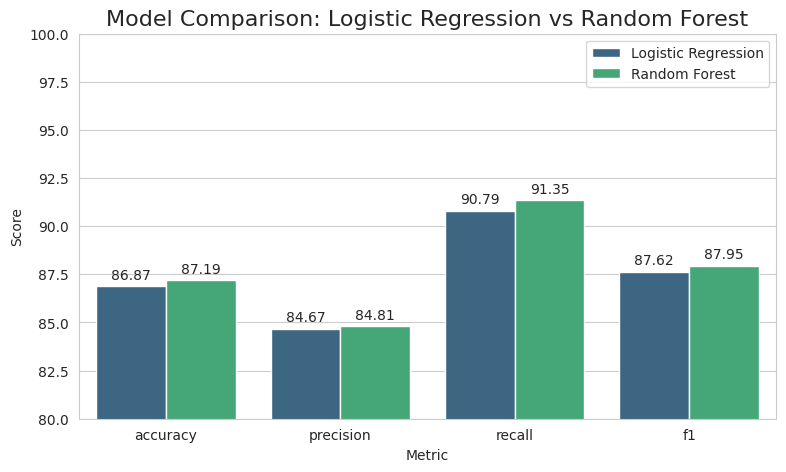

In [36]:
metrics_1 = ['accuracy', 'precision', 'recall', 'f1']
df_results_1 = df_results[df_results['Metric'].isin(metrics_1)].copy()
df_results_1_melted = df_results_1.melt(id_vars="Metric", var_name="Model", value_name="Score")


with sns.axes_style("whitegrid"):
  plt.figure(figsize=(9, 5))

  ax = sns.barplot(
      x="Metric",
      y="Score",
      hue="Model",
      data=df_results_1_melted,
      palette="viridis"
  )

  for container in ax.containers:
      ax.bar_label(container, fmt='%.2f', padding=3)

  plt.title("Model Comparison: Logistic Regression vs Random Forest", fontsize=16)
  plt.ylabel("Score")
  plt.ylim(80, 100)
  plt.legend()
  plt.show()

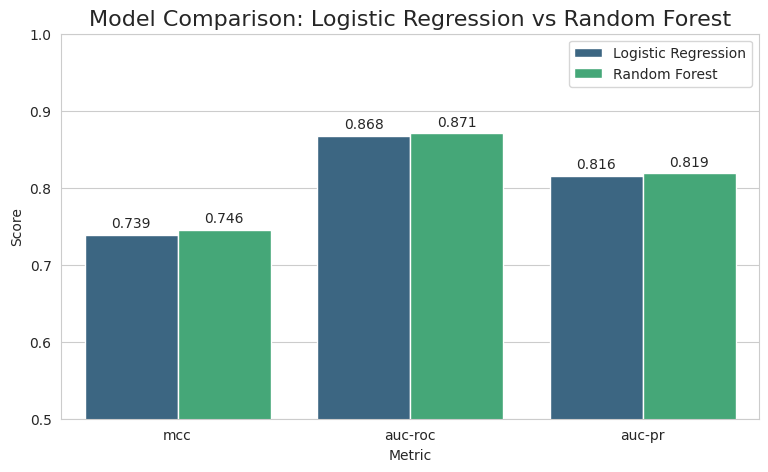

In [37]:
metrics_2 = ['mcc', 'auc-roc', 'auc-pr']
df_results_2 = df_results[df_results['Metric'].isin(metrics_2)].copy()
df_results_2_melted = df_results_2.melt(id_vars="Metric", var_name="Model", value_name="Score")


with sns.axes_style("whitegrid"):
  plt.figure(figsize=(9, 5))

  ax = sns.barplot(
      x="Metric",
      y="Score",
      hue="Model",
      data=df_results_2_melted,
      palette="viridis"
  )

  for container in ax.containers:
      ax.bar_label(container, fmt='%.3f', padding=3)

  plt.title("Model Comparison: Logistic Regression vs Random Forest", fontsize=16)
  plt.ylabel("Score")
  plt.ylim(0.5, 1)
  plt.legend()
  plt.show()